In [166]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import re

from scipy.optimize import curve_fit
import skrf as rf
import scqubits as scq

from pyawr_utils import awrde_utils
from texttable import Texttable

# 1. Define Subroutines

### 1.1 Import Admittance Trace

In [91]:
def extract_admittance_traces(graph_name, number_of_ports, plot_admittance=False):

    print(f'Loading graph {graph_name}')
    
    graphs_dict = project.graph_dict  

    graph = graphs_dict[graph_name]        

    meas_dict = graph.measurements_dict
    
    matrix_element_name_to_frequencies = {}
    matrix_element_name_to_admittance = {}
    
    # find which matrix element the trace corresponds to
    matrix_element_regex = re.compile(r"Im\(Y\((?P<i>\d),(?P<j>\d).*")
    
    number_of_frequency_points = meas_dict[0].trace_data[0].shape[0]
    
    y_matrix = np.empty((number_of_frequency_points, number_of_ports, number_of_ports), dtype='complex')
    
    for meas in meas_dict.values():
        
        trace_data_list = meas.trace_data 
        trace_data = trace_data_list[0]


        frequencies = trace_data[:,0]
        admittance = trace_data[:,1]*1j
        
        match = matrix_element_regex.search(meas.measurement_name)
        groupdict = match.groupdict()
        
        i = int(groupdict['i']) - 1
        j = int(groupdict['j']) - 1
        
        
        y_matrix[:, i, j] = admittance
        if i != j:
            y_matrix[:, j, i] = admittance
        
        

        if plot_admittance:
            plt.plot(frequencies, admittance.imag, label='meas.measurement_name')

            plt.xlabel('Frequency (GHz)')
            plt.ylabel('Admittance')
            plt.legend()
            plt.title(graph_name)
            plt.show() 


    return frequencies, y_matrix

### 1.2 Extract circuit parameters from vector fitting

In [108]:
def get_vector_fit(frequencies, y_matrix, number_of_complex_poles=1, plot_fits=False):
    '''
    :param frequencies: frequencies in GHz
    :return: vector fit object
    '''
    
    number_of_ports = y_matrix.shape[1]
    
    assert number_of_ports == y_matrix.shape[2]
    
    frequencies_Hz = frequencies * 1e9
    network = rf.Network(frequency=frequencies_Hz, y=y_matrix)
    vector_fit = rf.VectorFitting(network)
    
    vector_fit.vector_fit(n_poles_real=0, n_poles_cmplx=number_of_complex_poles, parameter_type='y', fit_constant=False, fit_proportional=True)

    print('Found fit with the following errors:')
    for i in range(number_of_ports):
        for j in range(i, number_of_ports):

            print(f'\tRMS error y{i+1}{j+1} = {vector_fit.get_rms_error(i, j, parameter_type="y")}')
            
    if plot_fits:
        model_frequencies = np.linspace(frequencies[0], frequencies[-1], 10001)*1e9

        for i in range(number_of_ports):
            for j in range(i, number_of_ports):

                model_yij = vector_fit.get_model_response(i, j, model_frequencies)

                plt.plot(frequencies, np.imag(y_matrix[:,i,j]), linestyle='', marker='o', label='data')
                plt.plot(model_frequencies/1e9, np.imag(model_yij), label='fit')

                plt.xlabel('Frequency (GHz)')
                plt.ylabel('Amplitude')

                plt.ylim(-0.01, 0.01)

                plt.legend()

                plt.title(f'Y{i+1}{j+1} fit')
                plt.show()
                
    return vector_fit

In [80]:
def extract_circuit_parameters(vector_fit, number_of_ports, print_values=False):
    '''
    put residues into NxN matrices where N is number of ports
    '''
    
    poles = vector_fit.poles
    residues = vector_fit.residues
    proportional_coeff = vector_fit.proportional_coeff
    
    number_of_poles = len(poles)

    # complex poles
    if number_of_poles > 1:
        residues_reshaped = np.real(np.reshape(residues, (number_of_ports, number_of_ports, number_of_poles)))
    else:
        residues_reshaped = np.real(np.reshape(residues, (number_of_ports, number_of_ports)))

    # perform SVD on each NxN residue matrix
    # len is number of poles, elements are M NxN rank 1 matrices where M is the rank of the original NxN residue matrix 
    r_vectors = []
    ranks = []

    for k in range(number_of_poles):

        if number_of_poles > 1:
            residue = residues_reshaped[:,:,k]
        else:
            residue = residues_reshaped

        rank = np.linalg.matrix_rank(residue)
        ranks.append(rank)

        U, S, V = np.linalg.svd(residue)

        if print_values:
            print(f'pole {k} singular values: {S}')

        r_vectors_k = np.zeros((rank, number_of_ports))

        for rank_index in range(rank):
            r_vectors_k[rank_index, :] = np.sqrt(2*S[rank_index])*U[:,rank_index]

        r_vectors.append(r_vectors_k)


    max_rank = np.max(ranks)

        
    # define circuit parameters for complex pole

    # total capacitances C_k
    C_k = 20e-15 # F
    C_ks = np.array([C_k]*number_of_poles*max_rank) 
    C_ks = np.reshape(C_ks, (number_of_poles, max_rank))


    # pole frequency omega_k
    omega_ks = np.imag(poles) # Hz * 2pi

    frequency_ks = omega_ks/2/np.pi # Hz

    if print_values:
        print(f'\nPole frequencies: {frequency_ks/1e9} GHz')


    # pole inductance L_k
    if print_values:
        print(f'\nMode inductances (nH)')
    L_ks = np.zeros((number_of_poles, max_rank))
    for k in range(number_of_poles):
        L_ks[k,:] = 1/(omega_ks[k]**2*C_ks[k,:]) # H

        if print_values:
            print(f'\tpole {k}: {L_ks[k,:] * 1e9}')


    # Coupling capacitances [C_ki]_j = sqrt(C_k)/(omega_k) [r_ki]_j

    C_coupling_ks = np.zeros((number_of_poles, max_rank, number_of_ports))

    if print_values:
        print('\nCoupling capacitances (fF)')
    for k in range(number_of_poles):
        for rank_index in range(max_rank):
            C_coupling_ks[k, rank_index, :] = np.sqrt(C_ks[k, rank_index])/omega_ks[k] * r_vectors[k][rank_index, :]


            if print_values:
                print(f'\tpole {k}, rank index {rank_index}: {C_coupling_ks[k, rank_index, :] * 1e15}')


    # capacitance to ground C_kig = C_k - sum_j [C_ki]_j
    C_g_ks = np.zeros((number_of_poles, max_rank))

    if print_values:
        print('\nPole capacitance to ground (fF)')
    for k in range(number_of_poles):
        for rank_index in range(max_rank):
            C_g_ks[k, rank_index] = C_ks[k, rank_index] - np.sum(C_coupling_ks[k, rank_index, :])

            if print_values:
                print(f'\tpole {k}, rank index {rank_index}: {C_g_ks[k, rank_index] * 1e15} fF')


    # fit proportional capacitance C_n
    C_n = np.reshape(proportional_coeff, (number_of_ports, number_of_ports)) # F
    if print_values:
        print(f'\nproportional coefficients (fF): \n{C_n * 1e-15}')
    
    
    
    # define capacitance matrix

    first_term = 0
    second_term = 0
    for k in range(number_of_poles):

        omega = omega_ks[k]

        if omega == 0:
            continue

        for rank_index in range(max_rank):

            r_vector = r_vectors[k][rank_index, :]

            first_term += np.outer(r_vector, r_vector)/(omega**2)

            second_term += - np.sqrt(C_ks[k, rank_index])/omega * np.diag(r_vector)


    cap_matrix = C_n + first_term + second_term

    cap_matrix_fF = cap_matrix * 1e15

    if print_values:
        print('Capacitance Matrix (fF)')
        print(cap_matrix_fF)

    # analyze capacitance matrix to get capacitances to ground

    capacitance_to_grounds = np.sum(cap_matrix, -1)
    if print_values:
        print(f'\nNode capacitance to grounds: {capacitance_to_grounds * 1e15} fF')
    
    
    
    circuit_parameters = {}

    for k in range(number_of_poles):
        for rank_index in range(max_rank):
            circuit_parameters[f'pole_inductance_{k*number_of_poles + rank_index}'] = L_ks[k, rank_index] * 1e9 # nH
            circuit_parameters[f'pole_capacitance_ground_{k*number_of_poles + rank_index}'] = C_g_ks[k, rank_index] * 1e15 # fF

            for i in range(number_of_ports):
                circuit_parameters[f'coupling_capacitance_{k*number_of_poles + rank_index}_{i}'] = C_coupling_ks[k, rank_index, i] * 1e15 # fF

    for i in range(number_of_ports):

        circuit_parameters[f'node_capacitance_ground_{i}'] = capacitance_to_grounds[i] * 1e15 # fF

        for j in range(number_of_ports):

            if i != j:
                circuit_parameters[f'internode_capacitance_{i}{j}'] = -cap_matrix_fF[i, j] # fF



    return circuit_parameters, number_of_poles, max_rank

### 1.3 Find Qubit and Coupler Capacitances

In [83]:
def find_qubit_capacitance():
    
    graph_name = 'Y_q'
    number_of_ports = 1
    
    frequencies, y_matrix = extract_admittance_traces(graph_name, number_of_ports)
    vector_fit = get_vector_fit(frequencies, y_matrix, 1)
    circuit_parameters, number_of_poles, max_rank = extract_circuit_parameters(vector_fit, number_of_ports)
    
    C_q_tot = 0

    for k in range(number_of_poles):
        for rank_index in range(max_rank):
            C_q_tot += circuit_parameters[f'coupling_capacitance_{k*number_of_poles + rank_index}_{0}']

    C_q_tot += circuit_parameters[f'node_capacitance_ground_{0}']

    return C_q_tot
    

In [85]:
def find_coupler_capacitance():
    
    graph_name = 'Y_c'
    number_of_ports = 1
    
    frequencies, y_matrix = extract_admittance_traces(graph_name, number_of_ports)
    vector_fit = get_vector_fit(frequencies, y_matrix, 1)
    circuit_parameters, number_of_poles, max_rank = extract_circuit_parameters(vector_fit, number_of_ports)
    
    C_c_tot = 0

    for k in range(number_of_poles):
        for rank_index in range(max_rank):
            C_c_tot += circuit_parameters[f'coupling_capacitance_{k*number_of_poles + rank_index}_{0}']

    C_c_tot += circuit_parameters[f'node_capacitance_ground_{0}']

    return C_c_tot
    

### 1.4 Set MWO Parameters

In [93]:
def set_qubit_frequency_equation(project, qubit_frequency):
    '''
    frequency in Hz
    '''
    global_def_dict = project.global_definitions_dict

    global_def = global_def_dict['Global Definitions']

    equations_dict = global_def.equations_dict

    for equation in equations_dict.values():
        if equation.equation_name == 'f_q':
            equation.equation_value = qubit_frequency
            
def set_coupler_frequency_equation(project, coupler_frequency):
    '''
    frequency in Hz
    '''
    global_def_dict = project.global_definitions_dict

    global_def = global_def_dict['Global Definitions']

    equations_dict = global_def.equations_dict

    for equation in equations_dict.values():
        if equation.equation_name == 'f_c':
            equation.equation_value = coupler_frequency
            
def set_qubit_capacitance_equation(project, qubit_capacitance):
    '''
    capacitance in F
    '''
    global_def_dict = project.global_definitions_dict

    global_def = global_def_dict['Global Definitions']

    equations_dict = global_def.equations_dict

    for equation in equations_dict.values():
        if equation.equation_name == 'C_q':
            equation.equation_value = qubit_capacitance
            
def set_coupler_capacitance_equation(project, coupler_capacitance):
    '''
    capacitance in F
    '''
    global_def_dict = project.global_definitions_dict

    global_def = global_def_dict['Global Definitions']

    equations_dict = global_def.equations_dict

    for equation in equations_dict.values():
        if equation.equation_name == 'C_c':
            equation.equation_value = coupler_capacitance

### 1.5 Extract coupling strength from avoided crossing

In [174]:
def create_qq_circuit_yaml(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances):
    
    yaml_str = 'branches:'
    
    total_num_poles = num_poles * num_ranks
    num_nodes = 1 + num_ports + total_num_poles
    
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            # add capacitances
            capacitance = None
    
            if i == 0:
                # ground to everything (capacitances)
                if j in range(1, 1 + num_ports):
                    capacitance = circuit_parameters[f'node_capacitance_ground_{j - 1}']
                elif j in range(1 + num_ports, 1 + num_ports + total_num_poles):
                    capacitance = circuit_parameters[f'pole_capacitance_ground_{j - 1 - total_num_poles}']
                    
                    inductance = circuit_parameters[f'pole_inductance_{j - 1 - total_num_poles}']
                    yaml_str += f'\n- ["L", {i}, {j}, {inductance}nH]'
                    
            elif i in range(1, 1 + num_ports):
                # q1, q2, c to everything (capacitance)
                if j in range(1, 1 + num_ports):
                    capacitance = circuit_parameters[f'internode_capacitance_{i - 1}{j - 1}']
                elif j in range(1 + num_ports, 1 + num_ports + total_num_poles):
                    capacitance = circuit_parameters[f'coupling_capacitance_{j - 1 - total_num_poles}_{i - 1}']
            
            if not capacitance is None:
                yaml_str += f'\n- ["C", {i}, {j}, {capacitance}fF]'
                
    # junctions: [EJ_q1, EJ_q2]
    EJ_q1, EJ_q2 = junction_EJs
    
    # parasitic capacitances: [C_parasitic_q1, C_parasitic_q2]
    C_parasitic_q1, C_parasitic_q2 = parasitic_capacitances
    
    # add qubit junctions
    yaml_str += f'\n- ["JJ", 0, 1, EJ_q1 = {EJ_q1}, {C_parasitic_q1}fF]'
    yaml_str += f'\n- ["JJ", 0, 2, EJ_q2 = {EJ_q2}, {C_parasitic_q2}fF]'
    
    return yaml_str
                    

In [175]:
def create_qq_circuit(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances):   
    circuit_yaml = create_qq_circuit_yaml(circuit_parameters, num_poles, num_ranks, num_ports, junction_EJs, parasitic_capacitances)
    circuit = scq.Circuit(circuit_yaml, from_file=False, ext_basis='harmonic', basis_completion='canonical')

    num_modes = num_ports + num_poles * num_ranks
    circuit.configure(np.identity(num_modes))
    
    circuit.cutoff_n_1 = 9
    circuit.cutoff_n_2 = 9
    circuit.cutoff_ext_3 = 4
    circuit.cutoff_ext_4 = 4
    
    return circuit

In [189]:
def qubit_frequency_vs_EJ_fit(x, a, b):
    return np.sqrt(8*x*a) + b

def EJ_vs_frequency(f, a, b):
    return np.power(f - b, 2)/(8*a)

In [263]:
def coupling_strength_fit(x, x0, Omega, a, c):
    return np.sqrt(np.power(a*(x-x0), 2) + np.power(Omega, 2)) + c

def coupling_strength_fit(x, x0, Omega, a):
    return np.sqrt(np.power(a*(x-x0), 2) + np.power(Omega, 2))

In [309]:
def extract_coupling_strength_from_avoided_crossing(qubit_parameters, coupler_frequency, coupling_fit_initial_guess=None):
    
    graph_name = 'Y_qq_leg'
    number_of_ports = 2
    
    frequencies, y_matrix = extract_admittance_traces(graph_name, number_of_ports)
    vector_fit = get_vector_fit(frequencies, y_matrix, number_of_complex_poles=1)
    circuit_parameters, number_of_poles, max_rank = extract_circuit_parameters(vector_fit, number_of_ports)
    
    ### parameters
    
    qubit_frequency = qubit_parameters['qubit_frequency']
    qubit_frequency_sweep = qubit_parameters['qubit_frequency_sweep']
    C_parasitic_q = qubit_parameters['C_parasitic_q']
    C_q_tot = qubit_parameters['C_q_tot']
    
    E_c = e*e/(2*C_q_tot*1e-15)/h/1e6 # MHz
    
    
    EJ_guess = np.power(qubit_frequency + E_c*1e-3, 2)/(8*E_c*1e-3)

    
    ### first sweep Q1 with Q2 far away
    
    junction_EJs = (EJ_guess, 4*EJ_guess)
    parasitic_capacitances = (C_parasitic_q, C_parasitic_q)
    
    
    circuit = create_qq_circuit(circuit_parameters, number_of_poles, max_rank, number_of_ports, junction_EJs, parasitic_capacitances)

    EJ_sweep = np.linspace(0.75*EJ_guess, 1.5*EJ_guess, 5)

    # Q1 bare frequencies
    
    q1_EJs = np.copy(EJ_sweep)
    q1_bare_frequencies = np.zeros(len(q1_EJs))
    for i in range(len(EJ_sweep)):
        EJ = EJ_sweep[i]
        circuit.EJ_q1 = EJ
        
        evals = circuit.eigenvals(2)

        if coupler_frequency > qubit_frequency:
            evals = circuit.eigenvals(2)
            q1_bare_frequencies[i] = evals[1] - evals[0]
        else:
            evals = circuit.eigenvals(3)
            q1_bare_frequencies[i] = evals[2] - evals[1]
        
    
    
    plt.plot(q1_EJs, q1_bare_frequencies*1000, marker='o', linestyle='', label='data')
    
    initial_guess = [E_c*1e-3, -E_c*1e-3]
    fit_EJs = np.linspace(EJ_sweep[0], EJ_sweep[-1], 1001)
    plt.plot(fit_EJs, qubit_frequency_vs_EJ_fit(fit_EJs, *initial_guess)*1000, label='initial guess')
    
    popt, pcov = curve_fit(qubit_frequency_vs_EJ_fit, q1_EJs, q1_bare_frequencies, p0=initial_guess)
   
    plt.plot(fit_EJs, qubit_frequency_vs_EJ_fit(fit_EJs, *popt)*1000, label='fit')
    
    
    plt.xlabel('EJ (GHz)')
    plt.ylabel('Frequency (MHz)')
    
    plt.title('Q1 bare frequencies fit')

    plt.legend()
    plt.show()
    
    def create_frequency_to_EJ_lambda(_popt):
        return lambda f: EJ_vs_frequency(f, *_popt)

    q1_frequency_to_EJ = create_frequency_to_EJ_lambda(popt)
    
    # Q2 bare frequencies
    circuit.EJ_q1 = 4*EJ_guess
    
    q2_EJs = np.copy(EJ_sweep)
    q2_bare_frequencies = np.zeros(len(q2_EJs))
    for i in range(len(EJ_sweep)):
        EJ = EJ_sweep[i]
        circuit.EJ_q2 = EJ
        

        if coupler_frequency > qubit_frequency:
            evals = circuit.eigenvals(2)
            q2_bare_frequencies[i] = evals[1] - evals[0]
        else:
            evals = circuit.eigenvals(3)
            q2_bare_frequencies[i] = evals[2] - evals[1]
            
    
    
    plt.plot(q2_EJs, q2_bare_frequencies*1000, marker='o', linestyle='', label='data')
    
    initial_guess = [E_c*1e-3, -E_c*1e-3]
    fit_EJs = np.linspace(EJ_sweep[0], EJ_sweep[-1], 1001)
    plt.plot(fit_EJs, qubit_frequency_vs_EJ_fit(fit_EJs, *initial_guess)*1000, label='initial guess')
    
    popt, pcov = curve_fit(qubit_frequency_vs_EJ_fit, q2_EJs, q2_bare_frequencies, p0=initial_guess)
   
    plt.plot(fit_EJs, qubit_frequency_vs_EJ_fit(fit_EJs, *popt)*1000, label='fit')
    
    
    plt.xlabel('EJ (GHz)')
    plt.ylabel('Frequency (MHz)')
    
    plt.title('Q2 bare frequencies fit')

    plt.legend()
    plt.show()
    
    q2_frequency_to_EJ = create_frequency_to_EJ_lambda(popt)
    
    
    
    ### now sweep Q2 through Q1 to find avoided crossing
    
    EJ_q1_static = q1_frequency_to_EJ(qubit_frequency)
    EJ_q2_sweep = q2_frequency_to_EJ(qubit_frequency_sweep)
    
    avoided_crossing_frequencies = np.zeros((len(EJ_q2_sweep), 2))
    
    circuit.EJ_q1 = EJ_q1_static
    
    for i in range(len(EJ_q2_sweep)):
        circuit.EJ_q2 = EJ_q2_sweep[i]
        
        if coupler_frequency > qubit_frequency:
            evals = circuit.eigenvals(3)
            avoided_crossing_frequencies[i,0] = evals[1] - evals[0]
            avoided_crossing_frequencies[i,1] = evals[2] - evals[0]
        else:
            evals = circuit.eigenvals(4)
            avoided_crossing_frequencies[i,0] = evals[2] - evals[0]
            avoided_crossing_frequencies[i,1] = evals[3] - evals[0]
        
    plt.plot(qubit_frequency_sweep*1000, avoided_crossing_frequencies[:,0]*1000, label='Q1 frequency')
    plt.plot(qubit_frequency_sweep*1000, avoided_crossing_frequencies[:,1]*1000, label='Q2 frequency')
    
#     plt.plot(q2_bare_frequencies*1000, q2_bare_frequencies*1000, linestyle=':', color='black', label='Q2 bare frequency')
#     plt.axhline(q1_bare_frequencies[len(q1_bare_frequencies)//2]*1000, linestyle='dashed', color='black', label='Q1 bare frequency')
    
    plt.xlabel('Q2 sweep frequency (MHz)')
    plt.ylabel('Frequency (MHz)')
        
    plt.legend() 
    plt.title('Q1 - Q2 Avoided Crossing')
    
    plt.show()
    
    ### calculate coupling strength from difference
    
    difference = avoided_crossing_frequencies[:,1] - avoided_crossing_frequencies[:,0]
    

    plt.plot(q2_bare_frequencies, difference, marker='o', linestyle='', label='data')

    if coupling_fit_initial_guess is None:
        coupling_fit_initial_guess = [qubit_frequency, 0.1, 0.6, 0]
        coupling_fit_initial_guess = [qubit_frequency, 0.04, 0.025]
#     print(f'coupling_fit_initial_guess: {coupling_fit_initial_guess}')
        
#     bounds = ((0,0,0,-0.1), (2*qubit_frequency, qubit_frequency, np.inf, 0.1))
    bounds = ((0,0,0), (2*qubit_frequency, qubit_frequency, np.inf))

    fit_frequencies = np.linspace(q2_bare_frequencies[0], q2_bare_frequencies[-1], 1001)

    plt.plot(fit_frequencies, coupling_strength_fit(fit_frequencies, *coupling_fit_initial_guess), label='initial guess')


    popt, pcov = curve_fit(coupling_strength_fit, q2_bare_frequencies, difference, p0=coupling_fit_initial_guess, bounds=bounds)
    plt.plot(fit_frequencies, coupling_strength_fit(fit_frequencies, *popt), label='fit')

    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Frequency Difference (GHz)')

    plt.legend()

    plt.show()

#     x0, Omega, a, c = popt
    x0, Omega, a = popt

    c = 0
    print(f'popt for coupling strength fit: {popt}')
    coupling_strength = (np.abs(Omega) + c)/2*1000 # MHz

    # coupling is negative if coupler is above qubit in frequency
    if coupler_frequency > qubit_frequency:
        coupling_strength *= -1
    
    return coupling_strength

# 2.

In [156]:
awrde = awrde_utils.establish_link()   #Establish link between Python and AWRDE
project = awrde_utils.Project(awrde)    #Assign object variable to Project class
#
project_name = project.project_name      #Get name of currently open project

expected_project_name = '8Q_triangle_lattice_capacitave_coupling_vector_fitting.emp'
try:
    assert project_name == expected_project_name
except:
    print(f'Need to open correct project. Got {project_name}, expected {expected_project_name}')
else:
    print(f'Opened project: {project_name}')
    
project.simulate_analyze()

Need to open correct project. Got 8Q_triangle_lattice_capacitave_coupling _vector_fitting.emp, expected 8Q_triangle_lattice_capacitave_coupling_vector_fitting.emp


True

In [272]:
h = 6.626e-34
hbar = h/(2*np.pi)
e = 1.6e-19 # Coulombs

Phi0 = h/(2*e)

In [273]:
C_q_tot = find_qubit_capacitance()

print(f'Setting qubit capacitance to {C_q_tot} fF\n')
set_qubit_capacitance_equation(project, C_q_tot*1e-15)


C_c_tot = find_coupler_capacitance()

print(f'Setting coupler capacitance to {C_c_tot} fF')
set_coupler_capacitance_equation(project, C_c_tot*1e-15)



Loading graph Y_q
Found fit with the following errors:
	RMS error y11 = 3.533278795579372e-08
Setting qubit capacitance to 105.34766496622386 fF

Loading graph Y_c
Found fit with the following errors:
	RMS error y11 = 3.363179113107594e-08
Setting coupler capacitance to 97.51289277931565 fF


In [288]:
# set qubit parameters

# set qubit frequency and define qubit frequency sweep for avoided crossing
qubit_frequency = 5 # GHz
set_qubit_frequency_equation(project, qubit_frequency*1e9)

frequency_sweep_range = 0.02
frequency_sweep_points = 11
qubit_frequency_sweep = np.linspace(qubit_frequency - frequency_sweep_range, qubit_frequency + frequency_sweep_range, frequency_sweep_points)

C_parasitic_q = 12 # fF

qubit_parameters = {}

qubit_parameters['qubit_frequency'] = qubit_frequency
qubit_parameters['qubit_frequency_sweep'] = qubit_frequency_sweep
qubit_parameters['C_parasitic_q'] = C_parasitic_q
qubit_parameters['C_q_tot'] = C_q_tot


In [301]:
# define coupler frequencies

num_lower_points = 31
num_higher_points = 11

num_lower_points = 0
num_higher_points = 21

coupler_frequencies_lower = np.linspace(1, 4, num_lower_points) # GHz
coupler_frequencies_higher = np.linspace(6, 7, num_higher_points) # GHz

coupler_frequencies = np.concatenate([coupler_frequencies_lower, coupler_frequencies_higher])

print(coupler_frequencies)


[6.   6.05 6.1  6.15 6.2  6.25 6.3  6.35 6.4  6.45 6.5  6.55 6.6  6.65
 6.7  6.75 6.8  6.85 6.9  6.95 7.  ]


In [302]:
coupler_frequency_to_coupling_fit_initial_guess = {}

coupler_frequency_to_coupling_fit_initial_guess['6'] = [4.69228133, 0.10660338, 0.63233435, 0.09499935]

Setting coupler frequency to 6.0 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.785524276261475e-05
	RMS error y12 = 2.9685180725972492e-06
	RMS error y22 = 4.754990886004497e-05


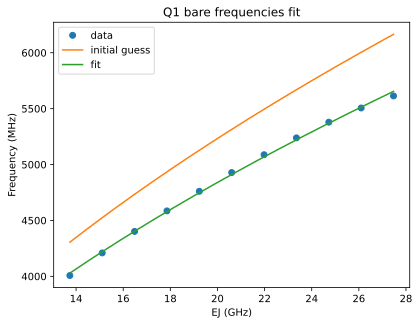

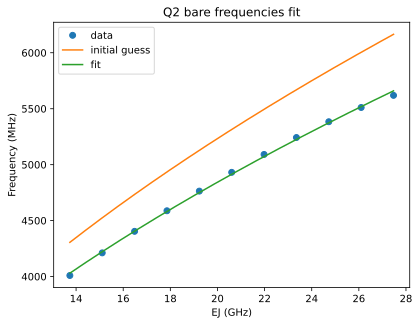

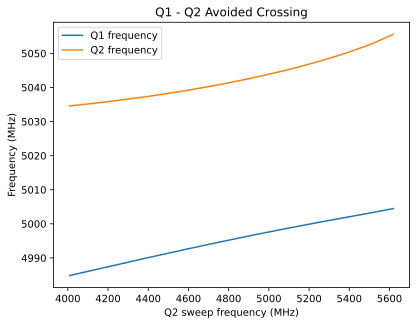

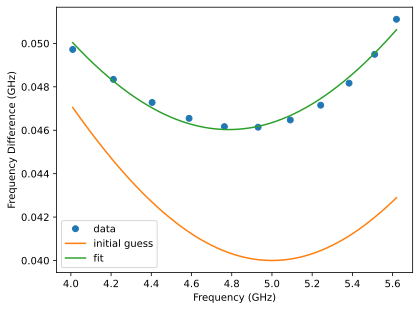

popt for coupling strength fit: [4.78511761 0.04603136 0.0252726 ]
coupling strength: 23.015680989949256 MHz


Setting coupler frequency to 6.05 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.783984335555331e-05
	RMS error y12 = 3.259283825650616e-06
	RMS error y22 = 4.753721047468295e-05


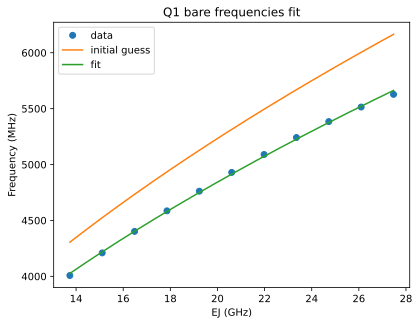

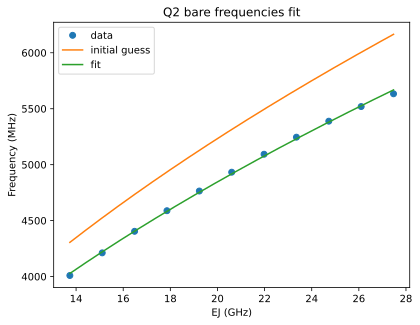

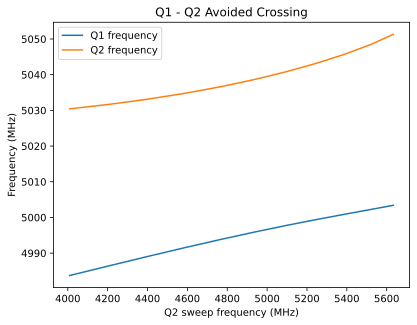

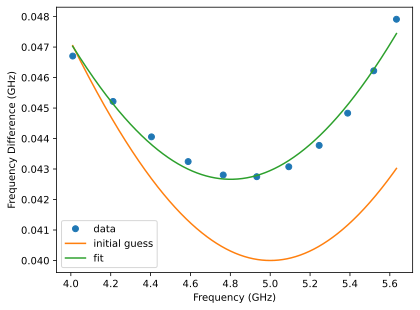

popt for coupling strength fit: [4.80179461 0.04266306 0.02495835]
coupling strength: 21.331528567198312 MHz


Setting coupler frequency to 6.1 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.788965438705401e-05
	RMS error y12 = 2.633634715318116e-06
	RMS error y22 = 4.758568094054363e-05


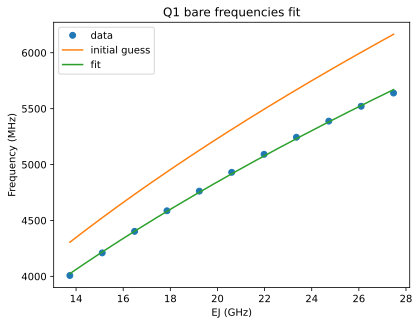

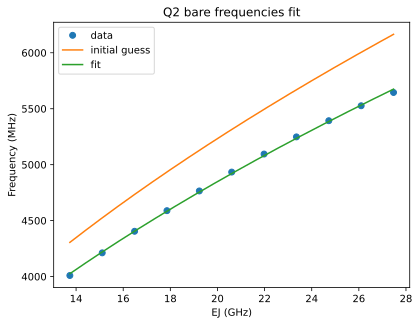

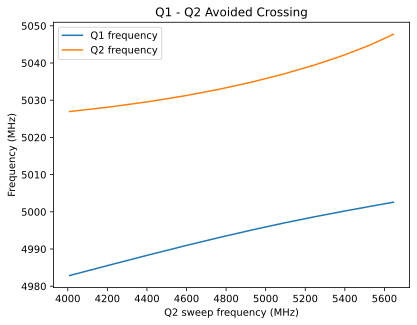

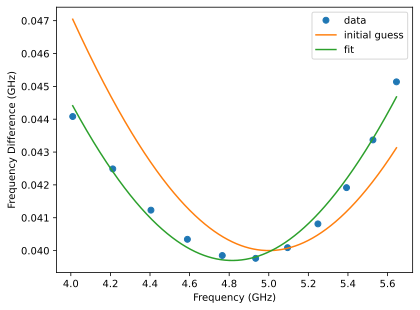

popt for coupling strength fit: [4.81528032 0.03969788 0.02470555]
coupling strength: 19.8489402432875 MHz


Setting coupler frequency to 6.15 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.791544418529701e-05
	RMS error y12 = 2.1246501550972693e-06
	RMS error y22 = 4.7611102766378695e-05


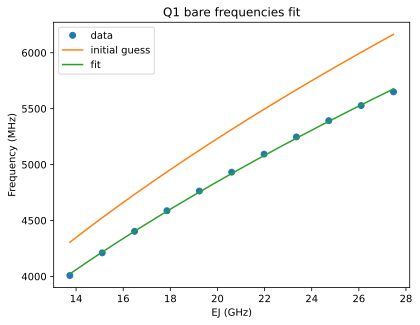

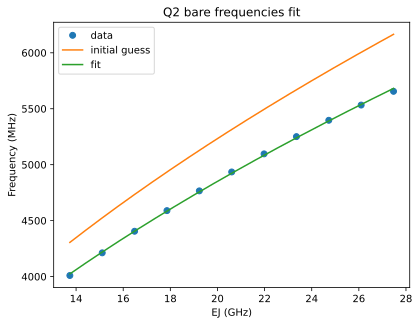

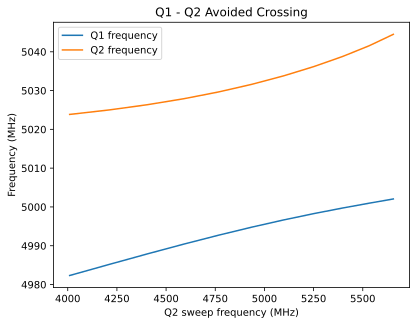

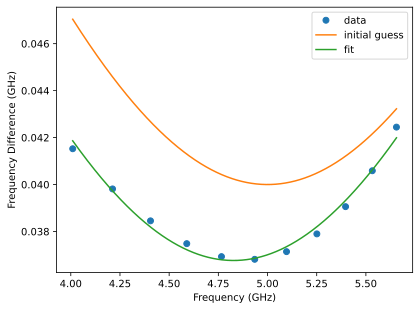

popt for coupling strength fit: [4.82712581 0.03676445 0.02449381]
coupling strength: 18.382225951587216 MHz


Setting coupler frequency to 6.2 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.787781345695042e-05
	RMS error y12 = 2.7147703370747143e-06
	RMS error y22 = 4.757507727698271e-05


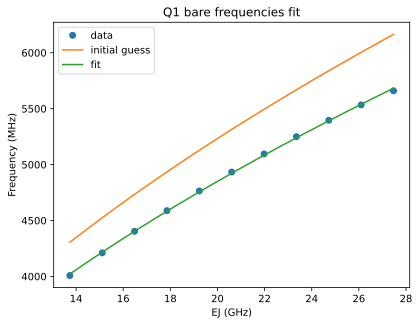

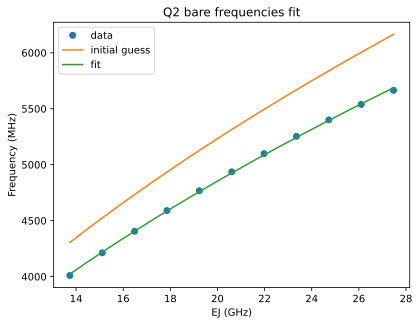

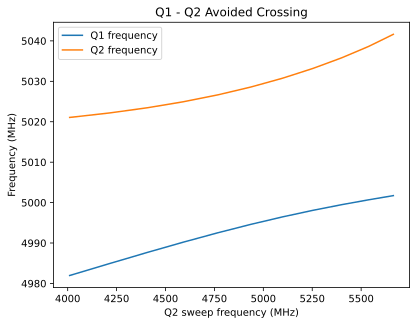

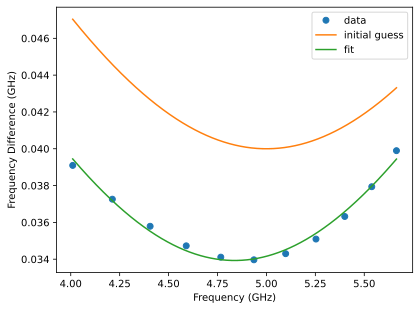

popt for coupling strength fit: [4.83758174 0.03392972 0.02431382]
coupling strength: 16.96485799445529 MHz


Setting coupler frequency to 6.25 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.7828243967727304e-05
	RMS error y12 = 3.1070641381461483e-06
	RMS error y22 = 4.752966757866691e-05


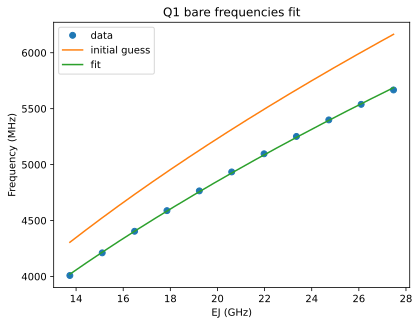

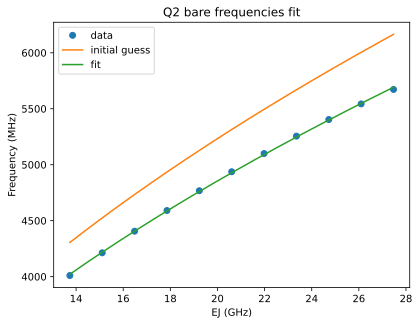

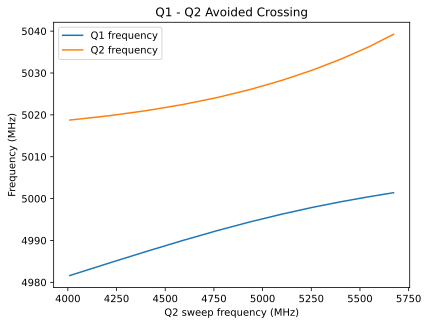

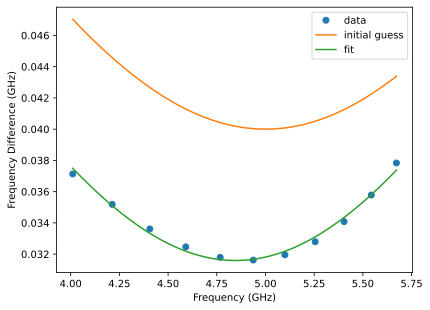

popt for coupling strength fit: [4.8459338  0.0315935  0.02416562]
coupling strength: 15.796751321809205 MHz


Setting coupler frequency to 6.3 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.783126119220772e-05
	RMS error y12 = 3.0947282224068366e-06
	RMS error y22 = 4.752800270965304e-05


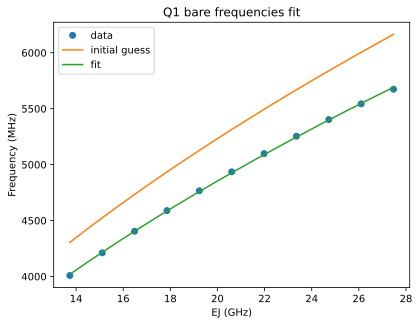

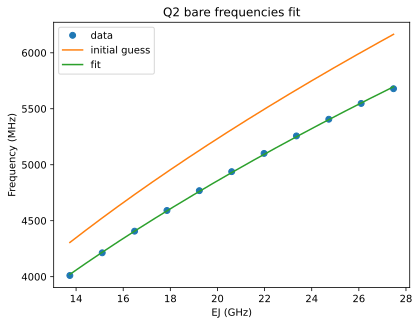

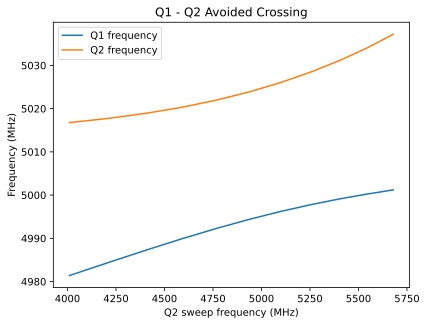

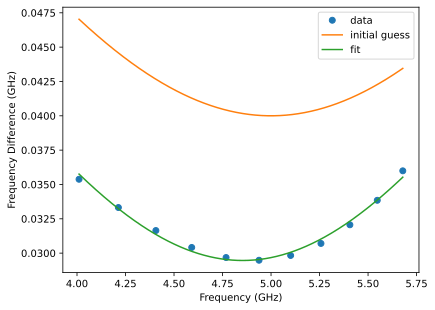

popt for coupling strength fit: [4.85308334 0.02946292 0.02404279]
coupling strength: 14.731460258979743 MHz


Setting coupler frequency to 6.35 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.7855623404922304e-05
	RMS error y12 = 2.926524126221679e-06
	RMS error y22 = 4.75533033622238e-05


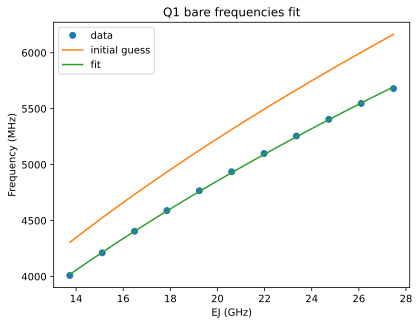

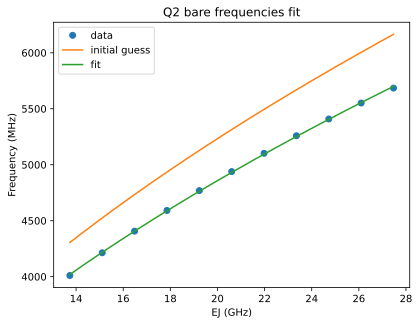

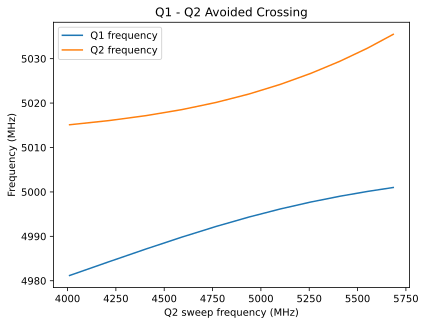

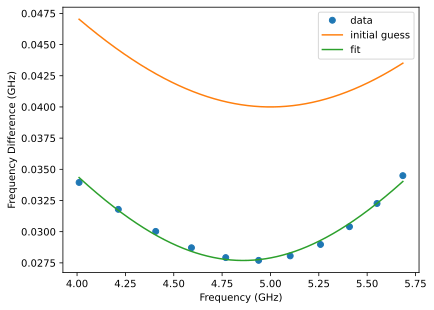

popt for coupling strength fit: [4.85869146 0.02768964 0.0239417 ]
coupling strength: 13.844819567018193 MHz


Setting coupler frequency to 6.4 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.790253895919114e-05
	RMS error y12 = 2.176325592323306e-06
	RMS error y22 = 4.759910493946333e-05


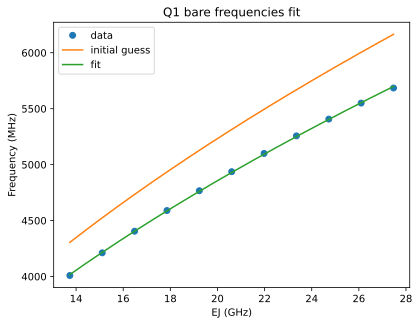

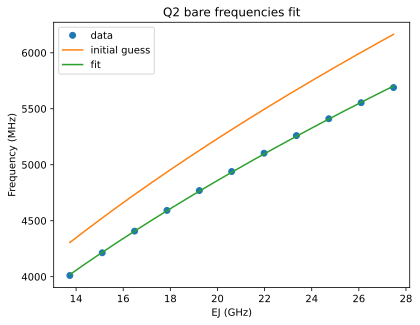

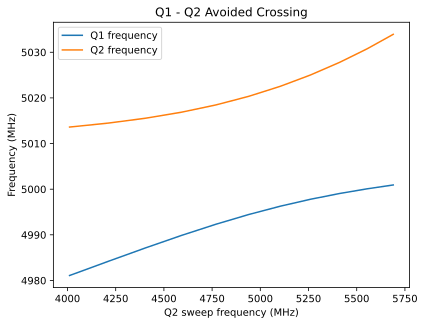

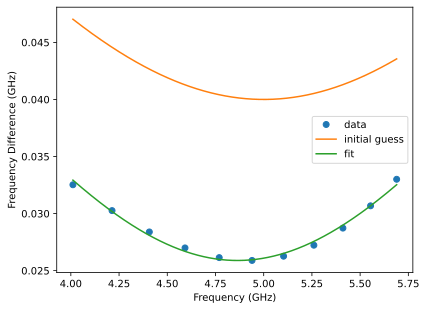

popt for coupling strength fit: [4.86381029 0.02588921 0.0238557 ]
coupling strength: 12.944605605743906 MHz


Setting coupler frequency to 6.45 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.788089323301963e-05
	RMS error y12 = 2.53406259394054e-06
	RMS error y22 = 4.757840951245663e-05


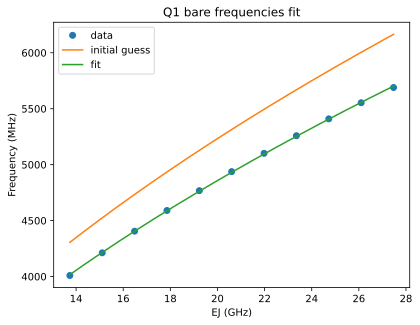

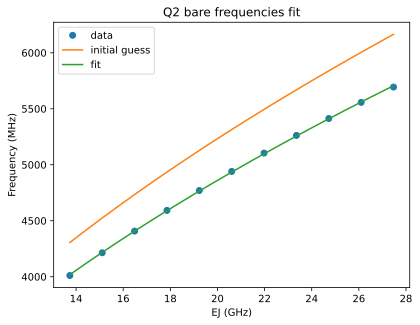

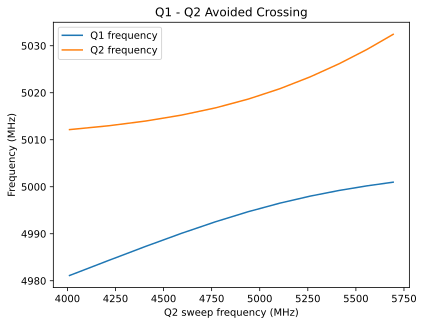

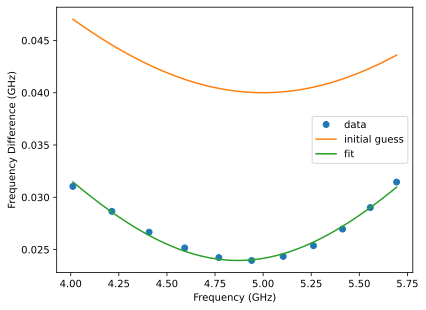

popt for coupling strength fit: [4.86885477 0.02395711 0.02377863]
coupling strength: 11.978554124011454 MHz


Setting coupler frequency to 6.5 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.7819345919313346e-05
	RMS error y12 = 3.2832243285844344e-06
	RMS error y22 = 4.7520033021659665e-05


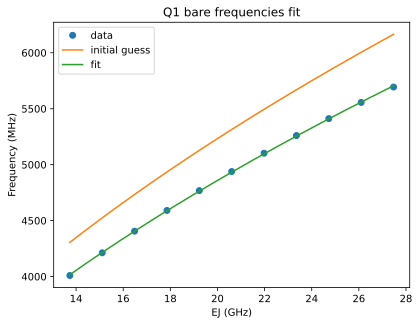

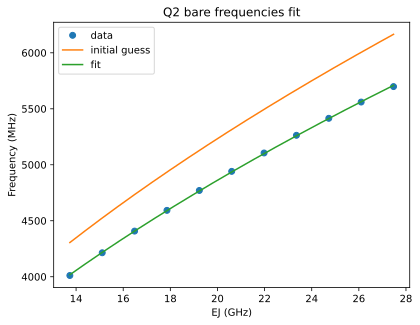

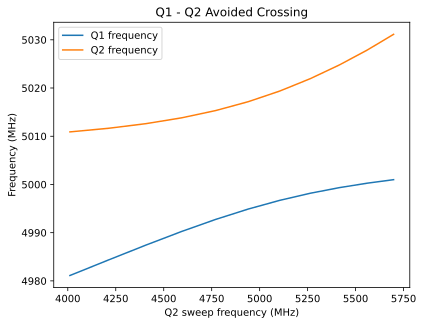

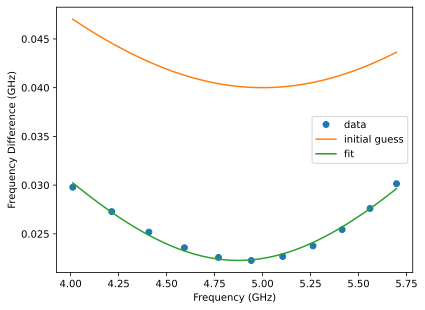

popt for coupling strength fit: [4.87320539 0.02227212 0.02371145]
coupling strength: 11.136061570626646 MHz


Setting coupler frequency to 6.55 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.991822417915888e-05
	RMS error y12 = 1.3886499733623149e-05
	RMS error y22 = 4.948344917260732e-05


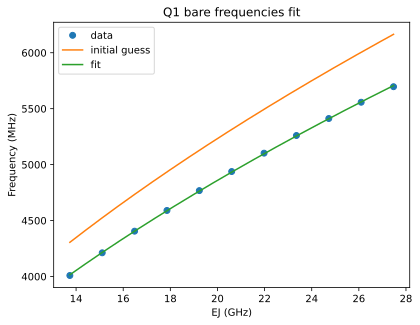

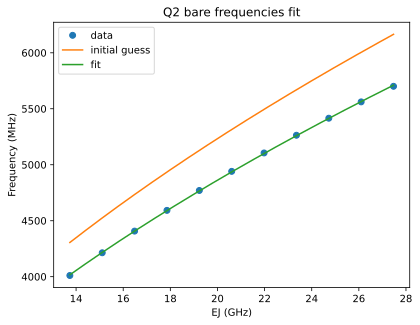

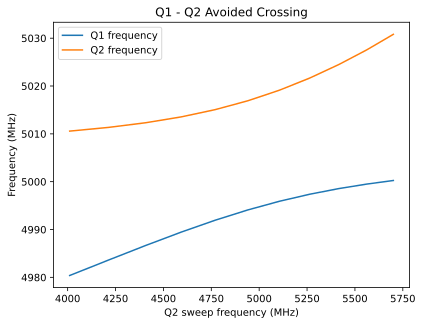

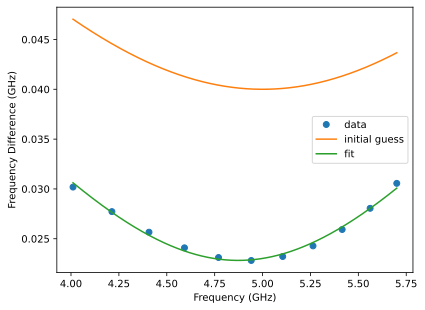

popt for coupling strength fit: [4.8728675  0.02282442 0.02366333]
coupling strength: 11.412211874824584 MHz


Setting coupler frequency to 6.6 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.7829140924738844e-05
	RMS error y12 = 2.9291674230407134e-06
	RMS error y22 = 4.7527501769388715e-05


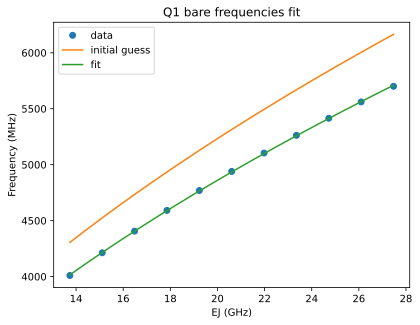

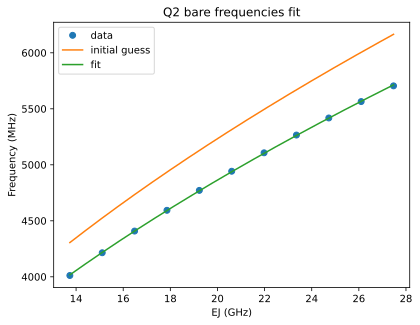

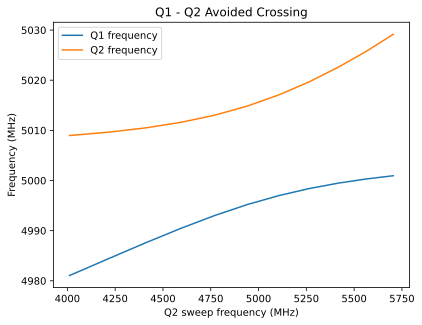

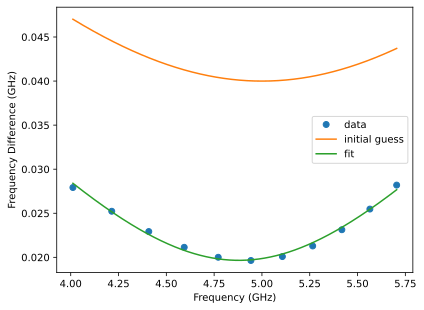

popt for coupling strength fit: [4.8797827  0.01965756 0.02360768]
coupling strength: 9.828777654136445 MHz


Setting coupler frequency to 6.65 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.788420760040589e-05
	RMS error y12 = 2.178240236520236e-06
	RMS error y22 = 4.7581343279347924e-05


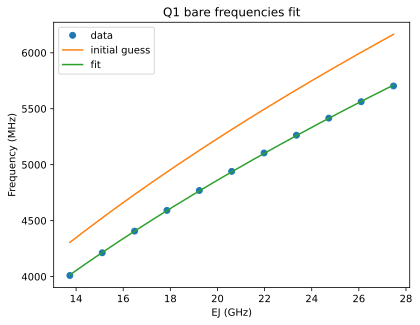

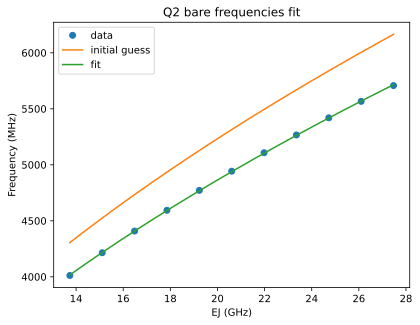

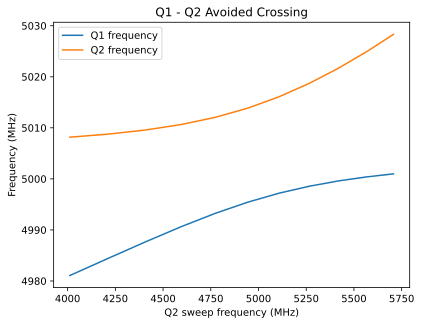

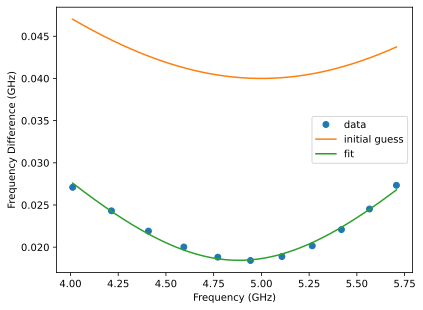

popt for coupling strength fit: [4.88251276 0.01844189 0.02356681]
coupling strength: 9.220943425301906 MHz


Setting coupler frequency to 6.7 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.786038423906156e-05
	RMS error y12 = 2.6398638550797454e-06
	RMS error y22 = 4.7558471710737624e-05


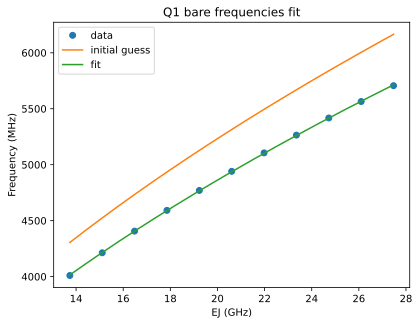

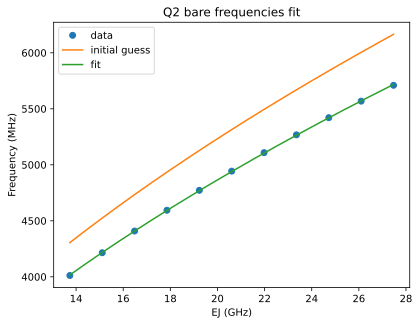

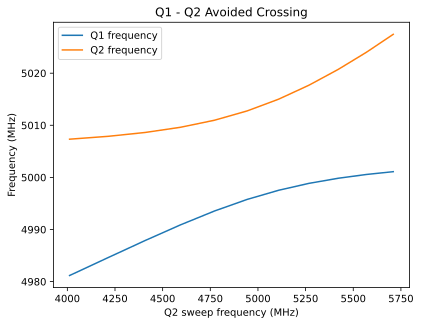

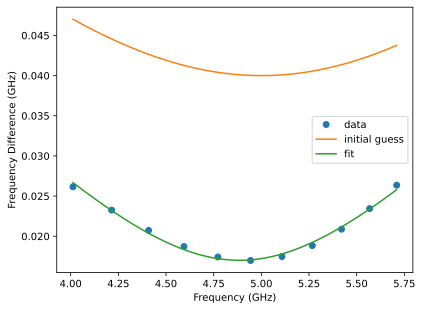

popt for coupling strength fit: [4.8855457  0.01700958 0.02352875]
coupling strength: 8.504790513598929 MHz


Setting coupler frequency to 6.75 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.780028023458764e-05
	RMS error y12 = 3.4944818369690137e-06
	RMS error y22 = 4.750124672614072e-05


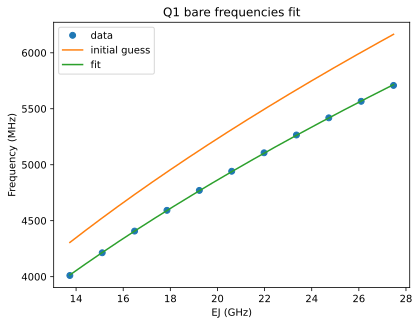

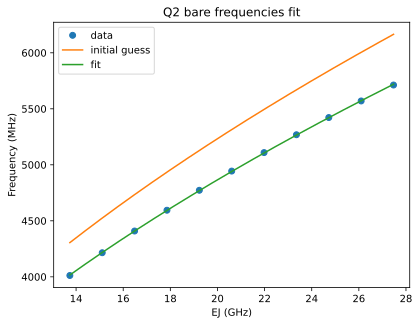

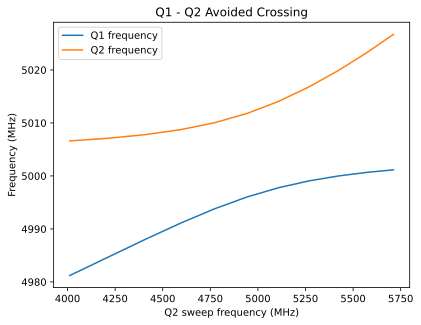

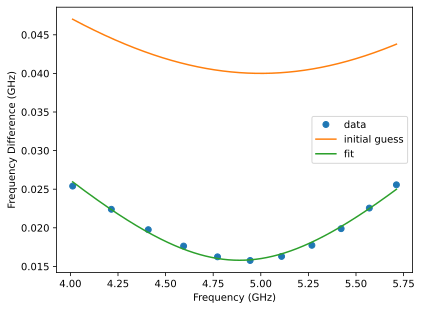

popt for coupling strength fit: [4.88820053 0.01579291 0.02349431]
coupling strength: 7.89645361416259 MHz


Setting coupler frequency to 6.8 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.8315020382316095e-05
	RMS error y12 = 6.282709038027736e-06
	RMS error y22 = 4.799553884119537e-05


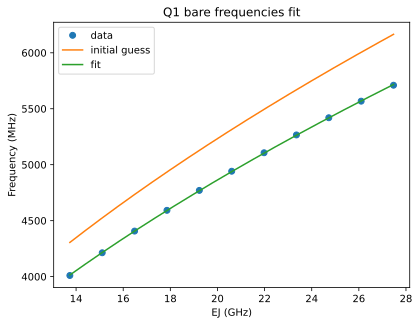

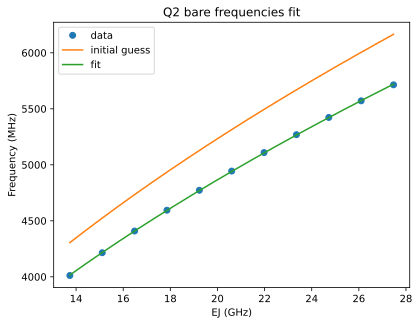

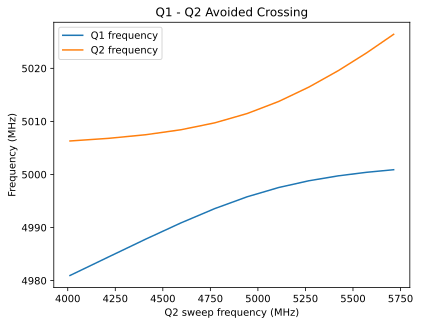

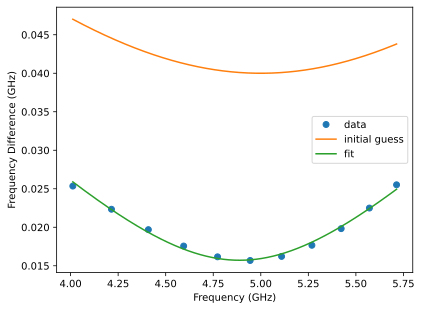

popt for coupling strength fit: [4.88870727 0.01571545 0.02346732]
coupling strength: 7.857722685834978 MHz


Setting coupler frequency to 6.85 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.780640252037503e-05
	RMS error y12 = 2.777710962295693e-06
	RMS error y22 = 4.7504944262386873e-05


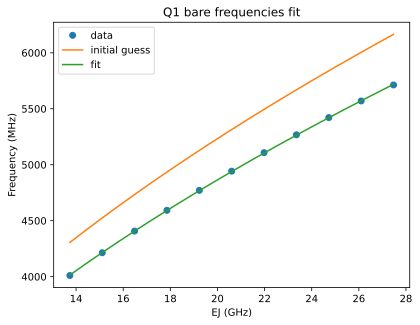

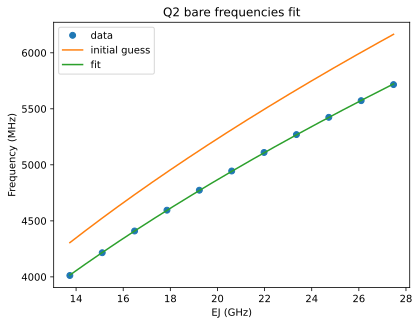

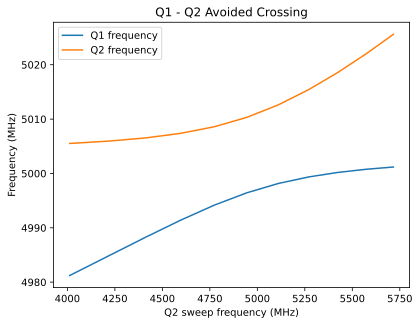

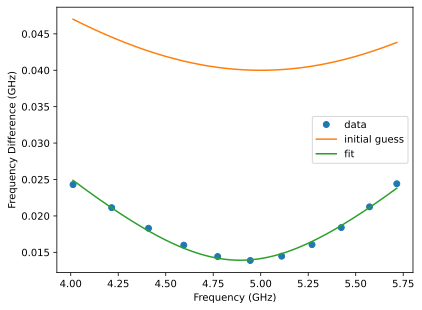

popt for coupling strength fit: [4.89231912 0.01391258 0.0234402 ]
coupling strength: 6.956288941904479 MHz


Setting coupler frequency to 6.9 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.7861630136455054e-05
	RMS error y12 = 2.158863097337434e-06
	RMS error y22 = 4.755911912536754e-05


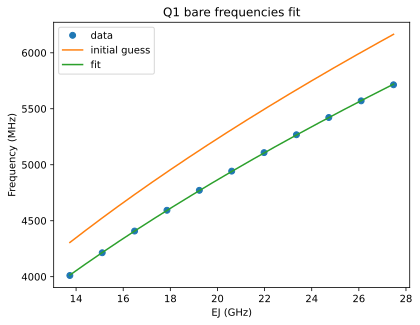

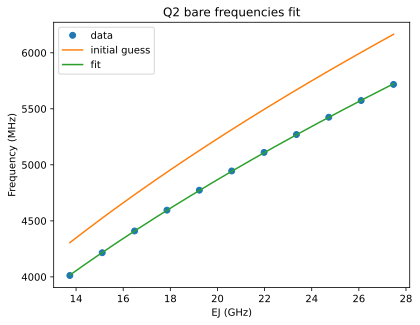

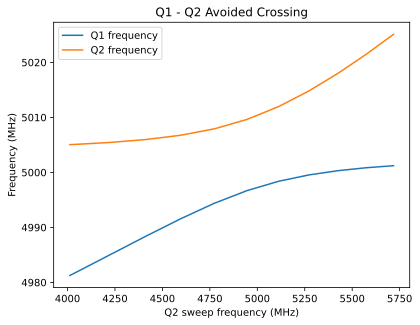

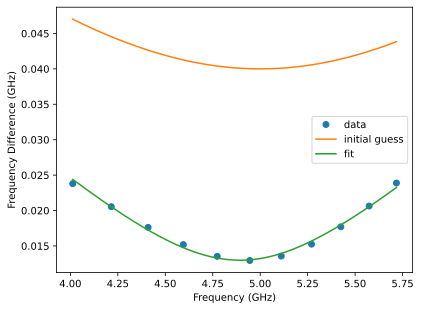

popt for coupling strength fit: [4.89415379 0.0129849  0.02341852]
coupling strength: 6.492452040579093 MHz


Setting coupler frequency to 6.95 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.781450448055234e-05
	RMS error y12 = 3.1389181914908596e-06
	RMS error y22 = 4.751351679359325e-05


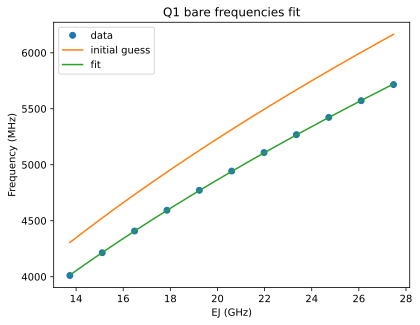

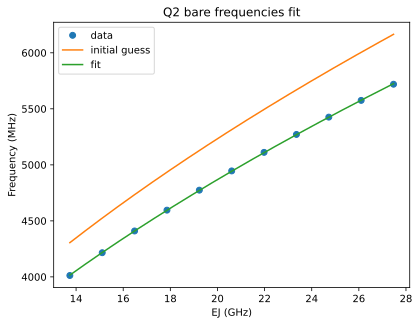

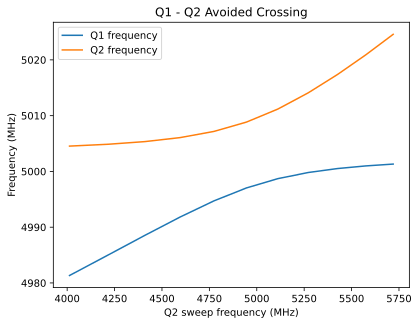

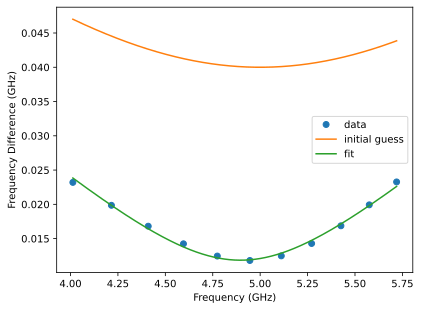

popt for coupling strength fit: [4.89639792 0.0118484  0.02339764]
coupling strength: 5.924198344318989 MHz


Setting coupler frequency to 7.0 GHz
Loading graph Y_qq_leg
Found fit with the following errors:
	RMS error y11 = 4.7798633614062136e-05
	RMS error y12 = 3.7762517093596064e-06
	RMS error y22 = 4.7499178366841256e-05


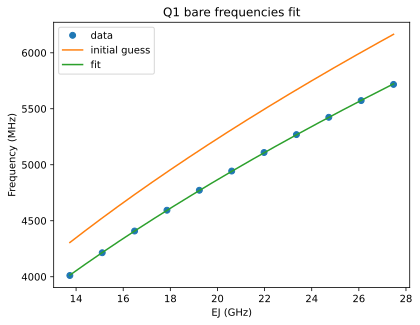

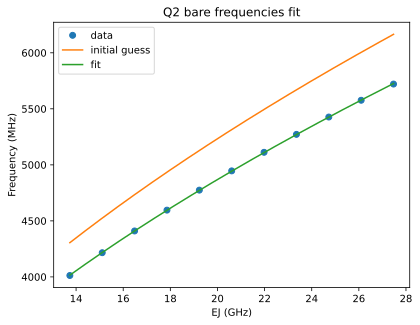

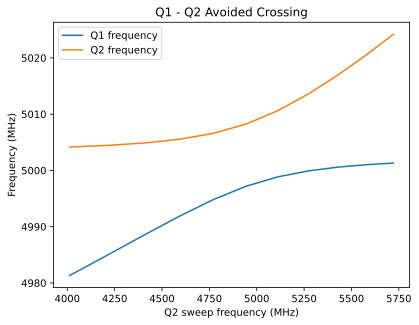

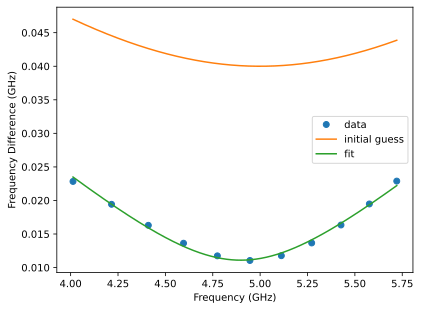

popt for coupling strength fit: [4.89801397 0.01109972 0.02337853]
coupling strength: 5.549858053584992 MHz




In [303]:
coupling_strengths = []
for i in range(len(coupler_frequencies)):
    
    coupler_frequency = coupler_frequencies[i]
    
    print(f'Setting coupler frequency to {coupler_frequency} GHz')
    
    set_coupler_frequency_equation(project, coupler_frequency*1e9)
    project.simulate_analyze()
    
    coupling_fit_initial_guess = None
    if str(coupler_frequency) in coupler_frequency_to_coupling_fit_initial_guess:
        coupling_fit_initial_guess = coupler_frequency_to_coupling_fit_initial_guess[str(coupler_frequency)]
    
    coupling_strength = extract_coupling_strength_from_avoided_crossing(qubit_parameters, coupler_frequency, coupling_fit_initial_guess=coupling_fit_initial_guess)
    
    print(f'coupling strength: {coupling_strength} MHz')
    
    print()
    print()
    
    coupling_strengths.append(coupling_strength)

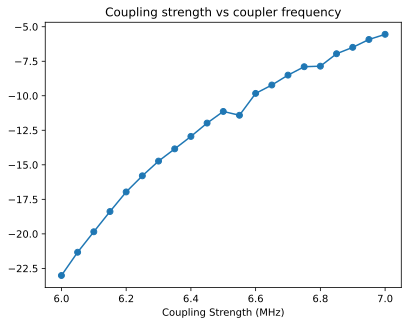

In [311]:
plt.plot(coupler_frequencies, -np.array(coupling_strengths), marker='o')

plt.xlabel('Coupler Frequency (GHz)')
plt.xlabel('Coupling Strength (MHz)')

plt.title('Coupling strength vs coupler frequency')
plt.show()

In [307]:
sweep_filename = r'8Q_vector_fitting_coupling_strength_sweeps\qq_leg.csv'
with open(sweep_filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Coupler Frequency (GHz)', 'Coupling Strength (MHz)'])
    for i in range(len(coupler_frequencies)):
        writer.writerow([coupler_frequencies[i], coupling_strengths[i]])
        